In [1]:
import os
import json
from typing import Dict, List
import requests
import pandas as pd 
import numpy as np
from bs4 import BeautifulSoup
import unicodedata
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from pprint import pprint
from requests import get

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from env import github_token
from env import github_username

import acquire_titanic

import prep

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer



Explore dataframes that are repositories that are in a github search of Titanic, and have the most starts. We pulled the top 180 repos

In [2]:
# Look at the data frame we have brought in.
df = acquire_titanic.scrape_github_data()
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 3 columns):
language           170 non-null object
readme_contents    180 non-null object
repo               180 non-null object
dtypes: object(3)
memory usage: 4.3+ KB


In [3]:
len(df)

180

Some of our repos do not have readme's

In [4]:
no_readme_df = df[df.readme_contents == 'error: no README']
no_readme_df

,language,readme_contents,repo
6,Jupyter Notebook,error: no README,minsuk-heo/kaggle-titanic
8,Jupyter Notebook,error: no README,shantnu/Titanic-Machine-Learning
26,Python,error: no README,mazurkin/titanic
74,Python,error: no README,codebugged/Titanic
88,Java,error: no README,joedayz/titanic-javaee7
90,R,error: no README,GeekyTheory/Taller-Big-Data-R-Titanic-IEEE
105,Python,error: no README,Mineria/Titanic
107,Jupyter Notebook,error: no README,MSusik/titanic
117,JavaScript,error: no README,ravinderpayal/Titanicturer
121,Jupyter Notebook,error: no README,mayank408/Data-Science-Hands-On


In [5]:
len(no_readme_df)

15

In [6]:
# make a copy of orginal df. This keeps the original df intact
#df_prep = df.copy()

In [7]:
df = df[df.readme_contents != 'error: no README']

In [8]:
len(df)

165

In [9]:
df = prep.prep_articles(df)

In [10]:
df.clean[112]

'titanicexample'

In [11]:
df.head()

,language,repo,original,stemmed,lemmatized,clean
0,JavaScript,icons8/titanic,# Titanic\n\nA collection of animated icons + ...,titan a collect of anim icon javascript librar...,titanic a collection of animated icon javascri...,collection animated icons javascript library p...
1,Java,romainpiel/Titanic,# Titanic for Android\n\nThis library is DEPRE...,titan for android thi librari is deprec as i d...,titanic for android this library is deprecated...,android library deprecated time mainatin anymo...
2,Jupyter Notebook,agconti/kaggle-titanic,### Kaggle-titanic\nThis is a tutorial in an I...,kaggletitan thi is a tutori in an ipython note...,kaggletitanic this is a tutorial in an ipython...,kaggletitanic tutorial kaggle competition disa...
3,Jupyter Notebook,HanXiaoyang/Kaggle_Titanic,# Kaggle_Titanic\nthe data and ipython noteboo...,kaggletitan the data and ipython notebook of m...,kaggletitanic the data and ipython notebook of...,kaggletitanic attempt solve kaggle problem kag...
4,R,trevorstephens/titanic,Titanic: Machine Learning from Disaster - Gett...,titan machin learn from disast get start with ...,titanic machine learning from disaster getting...,disaster getting started r trevor stephens jan...


In [12]:
df.language.value_counts(dropna=False)

Jupyter Notebook    74
Python              35
R                   15
NaN                 10
HTML                 9
JavaScript           6
Scala                4
Java                 3
F#                   2
C++                  1
Processing           1
PHP                  1
C                    1
Rust                 1
OpenEdge ABL         1
Clojure              1
Name: language, dtype: int64

In [13]:
labels = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
Jupyter Notebook,74,0.477419
Python,35,0.225806
R,15,0.096774
HTML,9,0.058065
JavaScript,6,0.038710
Scala,4,0.025806
Java,3,0.019355
F#,2,0.012903
C++,1,0.006452
Processing,1,0.006452


In [14]:
langs = list(labels.index)
langs

['Jupyter Notebook',
 'Python',
 'R',
 'HTML',
 'JavaScript',
 'Scala',
 'Java',
 'F#',
 'C++',
 'Processing',
 'PHP',
 'C',
 'Rust',
 'OpenEdge ABL',
 'Clojure']

In [15]:
counts = list(labels.n)
counts

[74, 35, 15, 9, 6, 4, 3, 2, 1, 1, 1, 1, 1, 1, 1]

In [16]:
langs_counts = []
for x in range(len(counts)):
    langs_counts.append(f'{counts[x]} {langs[x]}')
langs_counts

['74 Jupyter Notebook',
 '35 Python',
 '15 R',
 '9 HTML',
 '6 JavaScript',
 '4 Scala',
 '3 Java',
 '2 F#',
 '1 C++',
 '1 Processing',
 '1 PHP',
 '1 C',
 '1 Rust',
 '1 OpenEdge ABL',
 '1 Clojure']

In [17]:
import explore_charts

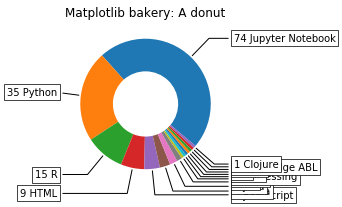

In [18]:
explore_charts.donut_chart(langs_counts, list(labels.n))

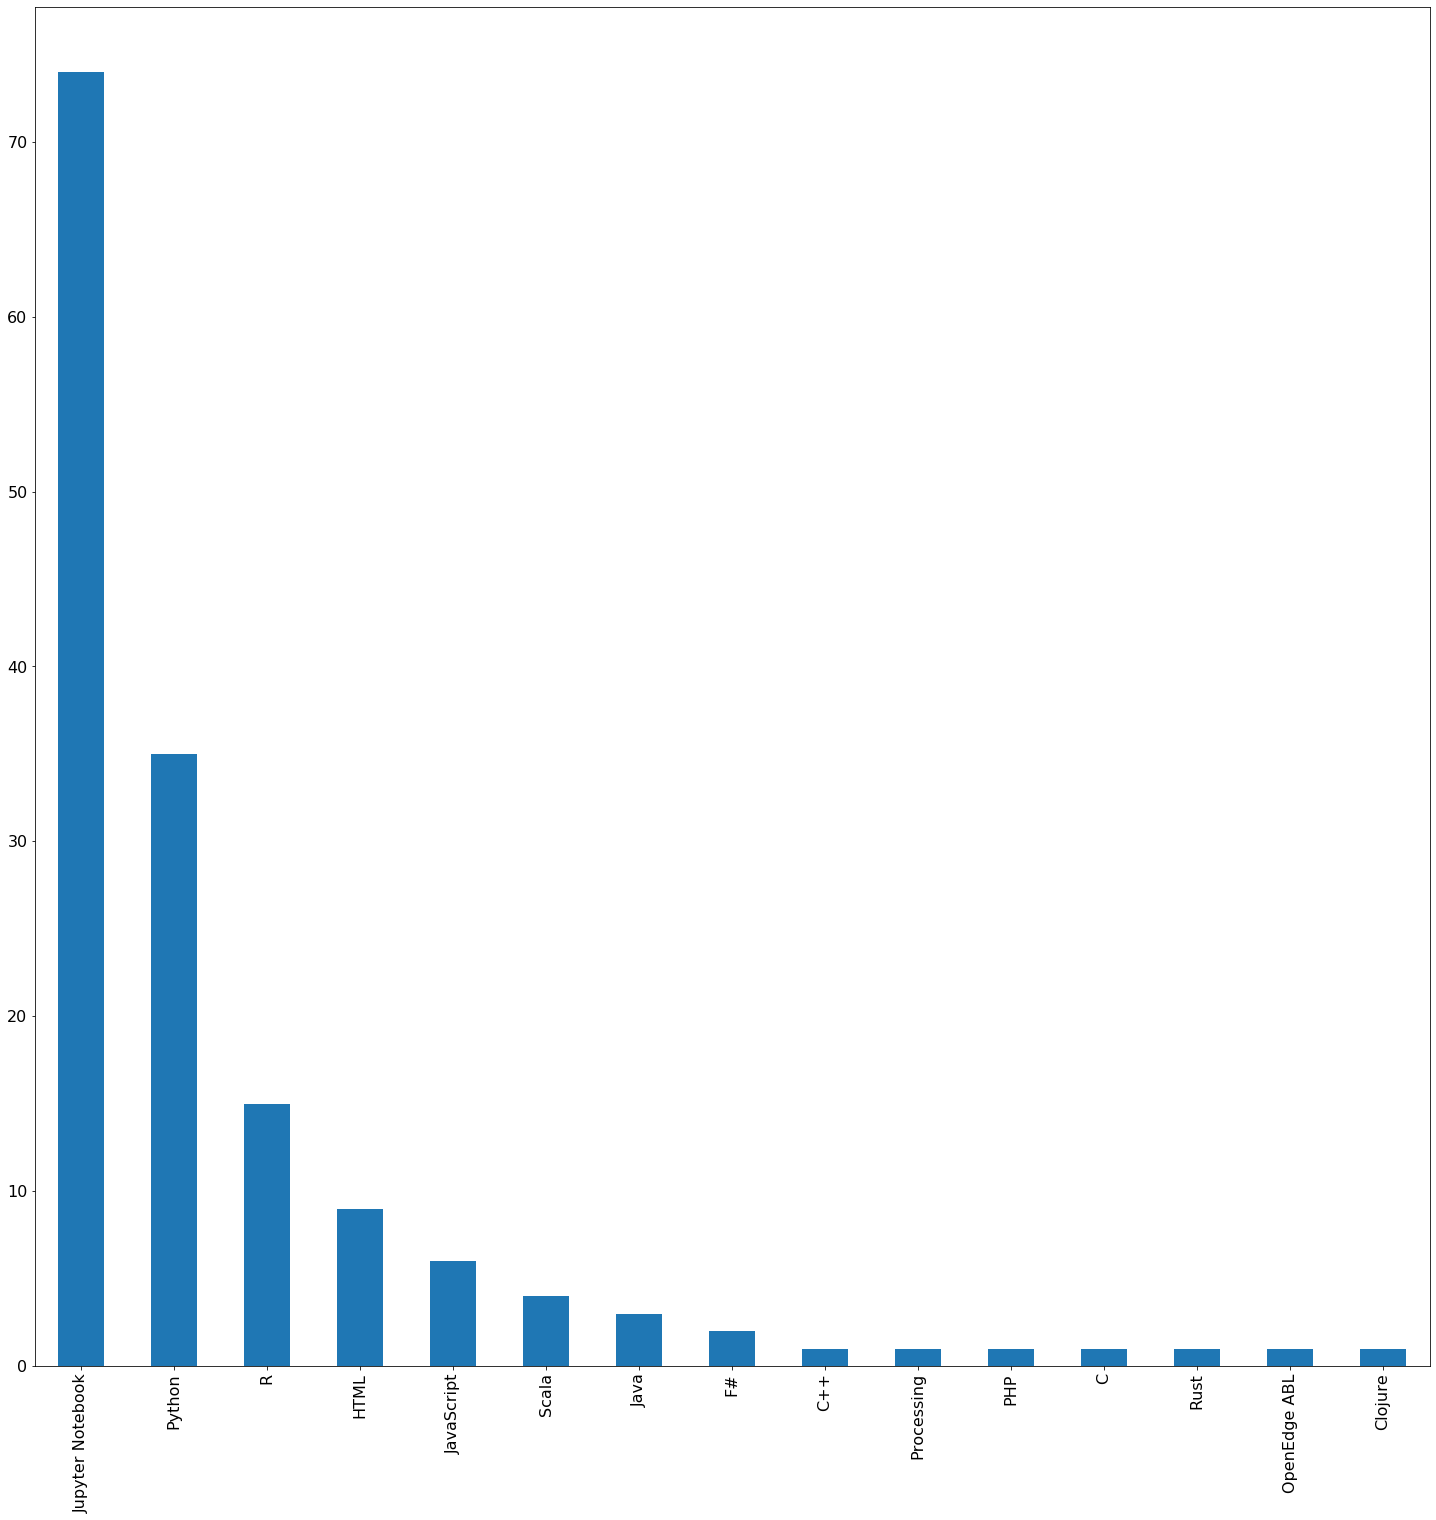

In [19]:
# explore the distribution of languages.
plt.rc('font', size=16)
plt.figure(figsize = (25,25))
labels.n.plot.bar()

In [20]:
df.columns

Index(['language', 'repo', 'original', 'stemmed', 'lemmatized', 'clean'], dtype='object')

looking

In [21]:
easy_df = df.drop(columns =(['repo', 'original', 'stemmed', 'lemmatized']))
easy_df

,language,clean
0,JavaScript,collection animated icons javascript library p...
1,Java,android library deprecated time mainatin anymo...
2,Jupyter Notebook,kaggletitanic tutorial kaggle competition disa...
3,Jupyter Notebook,kaggletitanic attempt solve kaggle problem kag...
4,R,disaster getting started r trevor stephens jan...
5,Jupyter Notebook,score 08134 kaggle challenge challenge kaggle ...
7,Jupyter Notebook,make first kaggle submission jupyter goes kagg...
9,Jupyter Notebook,important planning code along make sure clone ...
10,Python,kaggletitanic pythonscikitlearn code wrote sta...
11,Jupyter Notebook,27 numpyhttpwwwnumpyorg pandashttppandaspydata...


In [22]:
breakouts = pd.concat([easy_df.language.value_counts(),
                    easy_df.language.value_counts(normalize=True)], axis=1)
breakouts.columns = ['n', 'percent']
breakouts

,n,percent
Jupyter Notebook,74,0.477419
Python,35,0.225806
R,15,0.096774
HTML,9,0.058065
JavaScript,6,0.038710
Scala,4,0.025806
Java,3,0.019355
F#,2,0.012903
C++,1,0.006452
Processing,1,0.006452


In [23]:
all_text = " ".join(easy_df.clean)
all_text = all_text.split()
all_text_counts = pd.Series(all_text).value_counts()

javascript_text = " ".join(easy_df[easy_df.language == "JavaScript"].clean)
javascript_text = javascript_text.split()
javascript_text_counts = pd.Series(javascript_text).value_counts()

jupyter_text = " ".join(easy_df[easy_df.language == "Jupyter Notebook"].clean)
jupyter_text = jupyter_text.split()
jupyter_text_counts = pd.Series(jupyter_text).value_counts()

python_text = " ".join(easy_df[easy_df.language == "Python"].clean)
python_text = python_text.split()
python_text_counts = pd.Series(python_text).value_counts()

java_text = " ".join(easy_df[easy_df.language == "Java"].clean)
java_text = java_text.split()
java_text_counts = pd.Series(java_text).value_counts()

cplus_text = " ".join(easy_df[easy_df.language == "C++"].clean)
cplus_text = cplus_text.split()
cplus_text_counts = pd.Series(cplus_text).value_counts()

go_text = " ".join(easy_df[easy_df.language == "Go"].clean)
go_text = go_text.split()
go_text_counts = pd.Series(go_text).value_counts()


In [24]:
word_counts = (pd.concat([all_text_counts, javascript_text_counts, jupyter_text_counts, python_text_counts, java_text_counts, cplus_text_counts, go_text_counts], axis=1, sort=True)
                .set_axis(['all', 'javascript', 'jupyter', 'python', 'java', 'cplus', 'go'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))
word_counts

,all,javascript,jupyter,python,java,cplus,go
0000,1,1,0,0,0,0,0
0000048,1,0,1,0,0,0,0
00001,1,0,1,0,0,0,0
000010001,1,0,1,0,0,0,0
0001,4,0,4,0,0,0,0
0001115,1,0,1,0,0,0,0
0006316,1,0,1,0,0,0,0
0006750,1,0,1,0,0,0,0
001,5,0,5,0,0,0,0
005,4,0,4,0,0,0,0


In [25]:
word_counts.sort_values(by='all', ascending=False
                       ).head(10)

,all,javascript,jupyter,python,java,cplus,go
tr,884,0,884,0,0,0,0
td0td,658,0,658,0,0,0,0
td1td,383,0,383,0,0,0,0
1,224,1,193,14,1,0,0
tbody,160,0,160,0,0,0,0
nonnull,140,0,114,26,0,0,0
td3td,137,0,137,0,0,0,0
using,135,2,73,25,2,1,0
test,132,0,113,6,1,0,0
2,130,1,104,12,1,0,0


In [26]:
pd.concat([word_counts[word_counts.javascript == 0].sort_values(by='javascript').tail(6),
           word_counts[word_counts.jupyter == 0].sort_values(by='jupyter').tail(6),
          word_counts[word_counts.python == 0].sort_values(by='python').tail(6),
           word_counts[word_counts.java == 0].sort_values(by='java').tail(6),
           word_counts[word_counts.cplus == 0].sort_values(by='cplus').tail(6),
           word_counts[word_counts.go == 0].sort_values(by='go').tail(6)])

,all,javascript,jupyter,python,java,cplus,go
forests,7,0,2,2,0,0,0
forestrf,1,0,1,0,0,0,0
forestpros,1,0,1,0,0,0,0
foresthttpswwwkagglecombenhamnertitanicrandomforestbenchmarkrcode,1,0,1,0,0,0,0
gaussianpredictxtest,1,0,1,0,0,0,0
zstatistics,1,0,1,0,0,0,0
flat,1,1,0,0,0,0,0
flake8,2,0,0,2,0,0,0
flag,1,1,0,0,0,0,0
five,2,0,0,0,0,0,0


In [27]:
top_20_text_bigrams = (pd.Series(nltk.ngrams(all_text, 2))
                      .value_counts()
                      .head(20))

top_20_javascript = (pd.Series(nltk.ngrams(python_text, 2))
                      .value_counts()
                      .head(20))

top_20_jupyter_bigrams = (pd.Series(nltk.ngrams(jupyter_text, 2))
                      .value_counts()
                      .head(20))

top_20_python_bigrams = (pd.Series(nltk.ngrams(python_text, 2))
                      .value_counts()
                      .head(20))

top_20_java_bigrams = (pd.Series(nltk.ngrams(java_text, 2))
                      .value_counts()
                      .head(20))



top_20_cplus_bigrams = (pd.Series(nltk.ngrams(cplus_text, 2))
                      .value_counts()
                      .head(20))

top_20_go_bigrams = (pd.Series(nltk.ngrams(go_text, 2))
                      .value_counts()
                      .head(20))

# Modeling

In [28]:
tfidf = TfidfVectorizer()
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [29]:
# drop where language == None
easy_df = easy_df[easy_df.language.isna() == False]

In [30]:
value_counts_df = pd.DataFrame(easy_df.language.value_counts(dropna = False))
value_counts_df

,language
Jupyter Notebook,74
Python,35
R,15
HTML,9
JavaScript,6
Scala,4
Java,3
F#,2
C++,1
Processing,1


In [31]:
one_doc_langs = list(value_counts_df[value_counts_df.language < 2].index)
one_doc_langs

['C++', 'Processing', 'PHP', 'C', 'Rust', 'OpenEdge ABL', 'Clojure']

In [32]:
for x in one_doc_langs:
    easy_df = easy_df[easy_df.language != x]

In [33]:
easy_df.language.value_counts()

Jupyter Notebook    74
Python              35
R                   15
HTML                 9
JavaScript           6
Scala                4
Java                 3
F#                   2
Name: language, dtype: int64

In [34]:
X = tfidf.fit_transform(easy_df.clean)
X

<148x7202 sparse matrix of type '<class 'numpy.float64'>'
	with 13180 stored elements in Compressed Sparse Row format>

In [35]:
y= easy_df.language
y.head()

0          JavaScript
1                Java
2    Jupyter Notebook
3    Jupyter Notebook
4                   R
Name: language, dtype: object

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size = .3)

In [37]:
train = pd.DataFrame(dict(acutal = y_train))
train.head()

,acutal
17,Jupyter Notebook
158,Jupyter Notebook
38,Jupyter Notebook
101,R
84,Jupyter Notebook


In [38]:
test = pd.DataFrame(dict(actual=y_test))
test.head()

,actual
68,HTML
20,R
72,JavaScript
145,Jupyter Notebook
178,Jupyter Notebook


In [39]:
lm = LogisticRegression().fit(X_train, y_train)
lm

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [41]:
train

,acutal,predicted
17,Jupyter Notebook,Jupyter Notebook
158,Jupyter Notebook,Jupyter Notebook
38,Jupyter Notebook,Jupyter Notebook
101,R,Jupyter Notebook
84,Jupyter Notebook,Jupyter Notebook
179,Jupyter Notebook,Jupyter Notebook
154,F#,Jupyter Notebook
131,Python,Python
108,Python,Jupyter Notebook
114,Jupyter Notebook,Jupyter Notebook


In [42]:
accuracy_score(train.acutal, train.predicted)

0.5922330097087378

In [43]:
80/163

0.49079754601226994

In [44]:
accuracy_score(test.actual, test.predicted)

0.4888888888888889

In [45]:
print(classification_report(train.acutal, train.predicted))

                  precision    recall  f1-score   support

              F#       0.00      0.00      0.00         1
            HTML       0.00      0.00      0.00         6
            Java       0.00      0.00      0.00         2
      JavaScript       0.00      0.00      0.00         4
Jupyter Notebook       0.55      1.00      0.71        52
          Python       1.00      0.38      0.55        24
               R       0.00      0.00      0.00        11
           Scala       0.00      0.00      0.00         3

        accuracy                           0.59       103
       macro avg       0.19      0.17      0.16       103
    weighted avg       0.51      0.59      0.49       103



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [46]:
pd.crosstab(train.predicted, train.acutal)

acutal,F#,HTML,Java,JavaScript,Jupyter Notebook,Python,R,Scala
predicted,,,,,,,,
Jupyter Notebook,1,6,2,4,52,15,11,3
Python,0,0,0,0,0,9,0,0


In [47]:
easy_df = easy_df[easy_df.clean != 'error readme']
easy_df.head()

,language,clean
0,JavaScript,collection animated icons javascript library p...
1,Java,android library deprecated time mainatin anymo...
2,Jupyter Notebook,kaggletitanic tutorial kaggle competition disa...
3,Jupyter Notebook,kaggletitanic attempt solve kaggle problem kag...
4,R,disaster getting started r trevor stephens jan...


In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = .30, random_state = 123)
#X_train.head()

In [50]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=123)


In [51]:
clf.fit(X_train, y_train)


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [52]:
clf.score(X_train, y_train)

0.5631067961165048

In [53]:
clf.score(X_test, y_test)

0.5111111111111111

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [55]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=5, 
                            random_state=123)

In [56]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [57]:
y_pred = rf.predict(X_train)

In [58]:
rf.score(X_train,y_train)

0.5533980582524272

In [59]:
rf.score(X_test, y_test)

0.4666666666666667

In [60]:
from sklearn.preprocessing import PolynomialFeatures

In [61]:
poly = PolynomialFeatures(2)
poly

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [62]:
poly.fit(X_train, y_train)

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [63]:
poly.fit_transform(X_train)

<103x25945206 sparse matrix of type '<class 'numpy.float64'>'
	with 5819486 stored elements in Compressed Sparse Row format>

In [64]:
lm = LogisticRegression().fit(X_train, y_train)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
